### Let's review the basics


We want to do an inference problem in a Bayesian way but in high-dimensional space. Bayesian inference consists in computing a posterior distribution $p(\mathbf{x}|\mathbf{y})$ thanks to two things:
- prior: encoding our knowledge on what $\mathbf{x}$ should look like before doing the problem
- likelihood: encoding our physical model (and noise model) mapping a ground-truth $\mathbf{x}$ to an observation $\mathbf{y} = A\mathbf{x} + \eta$


At some point in our approach, we need to use Bayes' theorem to compute the posterior:

$$
p(\mathbf{x}|\mathbf{y}) 

= 

\frac{p(\mathbf{y}|\mathbf{x}) p(\mathbf{x}) }{p(\mathbf{y})}

=

\frac{ p(\mathbf{y}|\mathbf{x}) p(\mathbf{x})}{\int p(\mathbf{y}| \mathbf{x})p(\mathbf{x}) d\mathbf{x}}

$$

where I draw attention to the expression $p(\mathbf{y}) = \int p(\mathbf{y}|\mathbf{x}) p(\mathbf{x})dx $, the evidence which is basically a normalization to make sure that the posterior integrates to one. In high dimensions, computing this integral is very expensive (I think some methods exist to approximate this but I'm not sure, need to ask gpt). 


We now introduce a new notion, that is going to be crucial in what we're doing: the score. The score of a probability distribution $p(\mathbf{x})$ is defined as $\nabla_\mathbf{x} \log p(\mathbf{x})$. We can now rewrite Bayes' theorem using the score:

$$
\nabla_\mathbf{x} \log p(\mathbf{x} | \mathbf{y}) = \nabla_\mathbf{x} \log p(\mathbf{y}| \mathbf{x}) + \nabla_\mathbf{x} \log p(\mathbf{x})
$$

As you probably noticed, the rather troublesome term $p(\mathbf{y})$ completely vanished since we took the gradient with respect to $\mathbf{x}$.

Now where is ML in all of this ? Well, a score-based model is basically going to learn the score of a probability distribution. In the context of this notebook, our ML model is going to learn the score of the prior $\nabla_\mathbf{x} \log p(\mathbf{x})$. We don't go too much in the specificities of the training of a model in this notebook and we use an already trained score model (I'll let you guess who trained it...)

In [1]:
from score_models import ScoreModel
import torch 
import numpy as np 
import matplotlib.pyplot as plt
from torch.func import vmap, grad 
from tqdm import tqdm
plt.style.use("dark_background")

device  = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
# Loading the weights for a score model trained on a prior: 
score_model = ScoreModel(checkpoints_directory = "../../score_models/ncsnpp_probes_g_64_230604024652/")

# The diffusion noise 
def sigma(t): 
    return score_model.sde.sigma(t)

def mu(t): 
    return score_model.sde.marginal_prob_scalars(t)[0]

Using the Variance Exploding SDE


In [3]:
prior_samples = torch.load("../../../data/probes_prior_samples.pt")

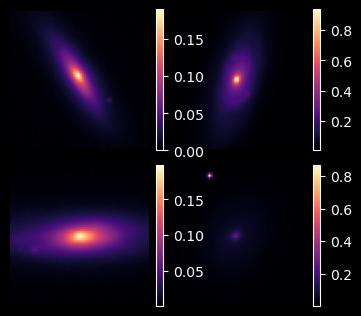

In [4]:
# The score model is trained in a [-1, 1] interval, to fix that when we sample we can use a link function:

def link_function(x):
    return  (x + 1) / 2

samples = link_function(prior_samples)
nrows = 2
ncols = 2
fig, axs = plt.subplots(nrows = nrows, ncols = ncols, figsize = (4, 4))

k = 0
for i in range(nrows): 
    for j in range(ncols): 
        im = axs[i, j].imshow(samples[k].squeeze().cpu().numpy(), cmap = "magma")
        axs[i, j].axis("off")
        plt.colorbar(im, ax = axs[i,j], fraction = 0.046)
        k+=1

plt.subplots_adjust(wspace = 0.02, hspace = 0.02)


Alright, now that we have prior samples thanks to our diffusion model (we also could have taken some random images from the dataset used to train the score model), let's rewind a bit on our first objective.

We want to infer posterior samples given a likelihood and a prior. Let's first create an observation assuming an isotropic gaussian likelihood:
$$
\begin{align}
\mathbf{y} &= A\mathbf{x} + \boldsymbol{\eta}

\\

p(\mathbf{y}|\mathbf{x}) &= \mathcal{N}(0, \sigma^2 \mathbf{I})

\end{align}
$$

For our tests, let's assume $A = \mathbf{I}$


In [65]:
samples.min()

tensor(0.4975, device='cuda:0')

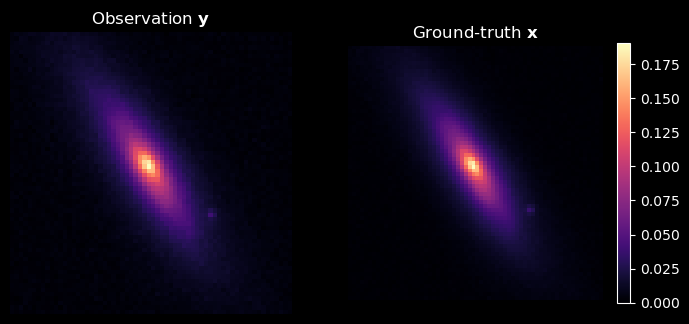

In [15]:

# Creating the observation
sigma_y = 1e-3

# Picking a ground-truth (let's take the most beautiful galaxy)
img_size = samples.shape[-1]
x = samples[0]
z = sigma_y * torch.randn_like(x, device = x.device)
y = x + z 


# Plot it to see:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (8, 4))

for i in range(len(axs)): 
    axs[i].axis("off")

axs[0].imshow(y.reshape(img_size, img_size).squeeze().cpu(), cmap = "magma")
axs[0].set_title(r"Observation $\mathbf{y}$")

im = axs[1].imshow(x.reshape(img_size, img_size).squeeze().cpu(), cmap = "magma")
axs[1].set_title(r"Ground-truth $\mathbf{x}$")
plt.colorbar(im, fraction = 0.046)

In [16]:
# To put in one file for sampling
def sigma(t): 
    return score_model.sde.sigma(t)

def mu(t): 
    return score_model.sde.marginal_prob_scalars(t)[0]

def drift_fn(t, x): 
    return score_model.sde.drift(t, x)

def g(t, x): 
    return score_model.sde.diffusion(t, x)

def model(x, t): 
    x = link_function(x)
    return x

def log_likelihood(y, x, t, sigma_y, forward_model):
    y_hat = forward_model(x, t) # model prediction
    var = sigma(t) ** 2 + mu(t)**2 * sigma_y ** 2 
    log_prob = - 0.5 * torch.sum((y_hat - mu(t) * y)**2/var)
    return log_prob

def score_likelihood(y, x, t, sigma_y, forward_model): 
    return vmap(grad(lambda x, t: log_likelihood(y, x, t, sigma_y, forward_model)), randomness = "different")(x, t)

def score_posterior(y, x, t, sigma_y, forward_model): 
    return score_model.score(t, x) + score_likelihood(y, x, t, sigma_y, forward_model)



t = torch.ones(size = (5, 1)).to(device)
x = torch.randn(size = (5, 1, 64, 64)).to(device)

score_posterior(y, x, t, sigma_y, forward_model = model).shape

torch.Size([5, 1, 64, 64])

In [36]:
def euler_sampler(y, sigma_y, forward_model, num_samples, num_steps, score_function, img_size = (64, 64)):
    t = torch.ones(size = (num_samples,1)).to(device)
    sigma_max = sigma(t)[0]
    x = sigma_max * torch.randn([num_samples, 1, *img_size]).to(device)
    dt = -1/num_steps 

    with torch.no_grad(): 
        for i in (pbar := tqdm(range(num_steps - 1))):
            pbar.set_description(f"t = {t[0].item():.2f} | scale ~ {x.std():.2e} | sigma(t) = {sigma(t)[0].item():.2e} | mu(t) = {mu(t)[0].item():.2e}")
            z = torch.randn_like(x).to(device)
            gradient = score_function(y, x, t, sigma_y, forward_model)
            drift = drift_fn(t, x)
            diffusion = g(t, x)
            x_mean  = x + drift * dt - diffusion ** 2 * gradient * dt
            noise = diffusion * (-dt) ** 0.5 * z
            x = x_mean + noise
            t += dt

            if torch.isnan(x).any().item(): 
                print("Nans appearing")
                break
    return link_function(x_mean)            

In [35]:
z = torch.tensor([1.0, 2.0, float('nan'), 4.0])
torch.isnan(z).any().item()

True

In [31]:
sigma(t)

tensor([[400.0000],
        [400.0000],
        [400.0000],
        [400.0000],
        [400.0000]], device='cuda:0')

In [37]:
num_samples = 1
num_steps = 1000 
posterior_samples = euler_sampler(y, sigma_y, model, num_samples, num_steps, score_posterior)

t = 0.96 | scale ~ nan | sigma(t) = 2.45e+02 | mu(t) = 1.00e+00:   4%|▍         | 38/999 [00:02<00:55, 17.38it/s]     

Nans appearing


(-0.5, 63.5, 63.5, -0.5)

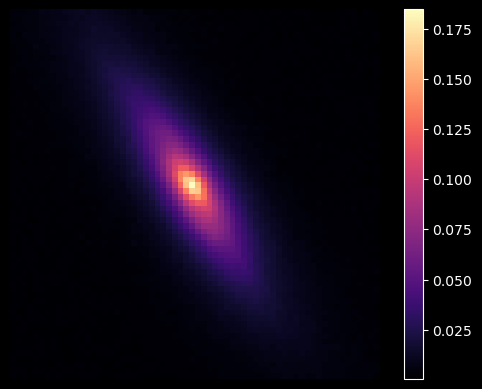

In [19]:
plt.imshow(posterior_samples.reshape(img_size, img_size).cpu(), cmap = "magma")
plt.colorbar()
plt.axis("off")

Same thing with a different forward model 

In [24]:
z = torch.tensor([1j +5, 1j])

In [5]:
import sys
sys.path.append("../models")
from gridding import ft, ift

In [6]:
def complex_to_real(z):
    """Convert a complex tensor into a real representation where the real
    part and the imaginary part are concatenated 

    Args:
        z (torch.Tensor): complex tensor of dimension D 

    Returns:
        real tensor of dimensions 2*D
    """
    return torch.cat([z.real, z.imag])   

def real_to_complex(x):
    """Convert a real representation of a complex tensor into its associated 
    complex tensor (see the description of the complex_to_real(*args) function)

    Args:
        z (torch.Tensor): real tensor of dimension 2*D 

    Returns:
        complex tensor of dimensions D
    """
    return x[0] + 1j * x[1]

In [47]:
data_path = "../../../data/"
S = torch.tensor(np.load(data_path + "data_htlup/sampling_function3.npy"))

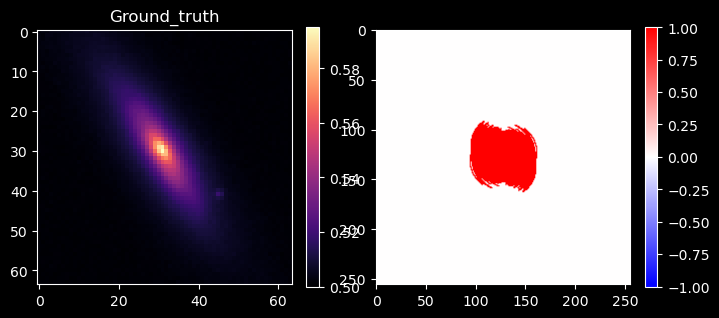

In [49]:
fig, axs = plt.subplots(1, 2, figsize = (2*4, 4))
im = axs[0].imshow(link_function(samples[0, 0]).cpu().numpy(), cmap = "magma")
axs[0].set_title("Ground_truth")
plt.colorbar(im, ax = axs[0], fraction = 0.046)

im = axs[1].imshow(torch.fft.fftshift(S[:256*256].reshape(256, 256)).cpu(), cmap = "bwr", vmin = -1)
plt.colorbar(im, ax = axs[1], fraction = 0.046)

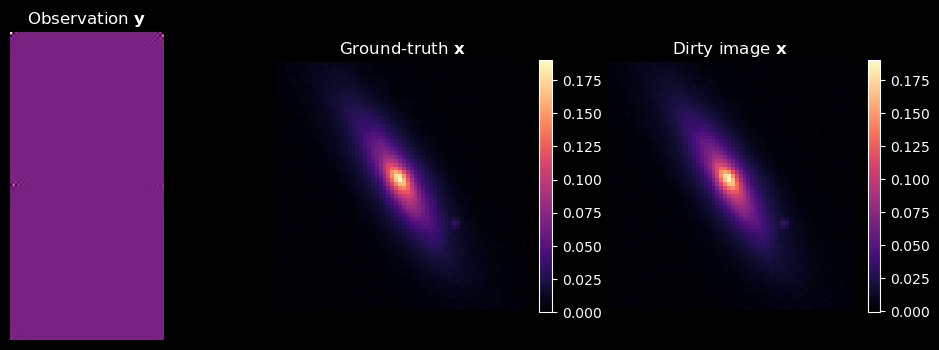

In [51]:

# Creating the observation
sigma_y = 1e-4

# Picking a ground-truth (let's take the most beautiful galaxy)
img_size = samples.shape[-1]
x = samples[0]

y_full = ft(x)

# Converting to the real representation
y = complex_to_real(y_full)

# Adding isotropic gaussian noise
y += sigma_y * torch.randn_like(y, device = x.device)

# Plot it to see:
fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (12, 4))

for i in range(len(axs)): 
    axs[i].axis("off")

axs[0].imshow(y.reshape(-1, img_size).squeeze().cpu(), cmap = "magma")
axs[0].set_title(r"Observation $\mathbf{y}$")

im = axs[1].imshow(x.reshape(img_size, img_size).squeeze().cpu(), cmap = "magma")
axs[1].set_title(r"Ground-truth $\mathbf{x}$")
plt.colorbar(im, fraction = 0.046)

dirty_image = real_to_complex(ift(y))
im = axs[2].imshow(dirty_image.reshape(img_size, img_size).real.squeeze().cpu(), cmap = "magma")
axs[2].set_title(r"Dirty image $\mathbf{x}$")
plt.colorbar(im, fraction = 0.046)

In [53]:
y.dtype

torch.float32

In [52]:
x.shape

torch.Size([1, 64, 64])

In [44]:
# To put in one file for sampling
def sigma(t): 
    return score_model.sde.sigma(t)

def mu(t): 
    return score_model.sde.marginal_prob_scalars(t)[0]

def drift_fn(t, x): 
    return score_model.sde.drift(t, x)

def g(t, x): 
    return score_model.sde.diffusion(t, x)

def model_ft(x, t): 
    x = link_function(x)
    y_full = ft(x)
    y = complex_to_real(y_full)
    return y

def log_likelihood(y, x, t, sigma_y, forward_model):
    y_hat = forward_model(x, t) # model prediction
    var = sigma(t) ** 2 + mu(t)**2 * sigma_y ** 2 
    log_prob = - 0.5 * torch.sum((y_hat - mu(t) * y)**2/var)
    return log_prob

def score_likelihood(y, x, t, sigma_y, forward_model): 
    return vmap(grad(lambda x, t: log_likelihood(y, x, t, sigma_y, forward_model)), randomness = "different")(x, t)

def score_posterior(y, x, t, sigma_y, forward_model): 
    return score_model.score(t, x) + score_likelihood(y, x, t, sigma_y, forward_model)



t = torch.ones(size = (5, 1)).to(device)
x = torch.randn(size = (5, 1, 64, 64)).to(device)

score_posterior(y, x, t, sigma_y, forward_model = model_ft).shape

torch.Size([5, 1, 64, 64])

In [45]:
num_samples = 1
num_steps = 1000 
posterior_samples = euler_sampler(y, sigma_y, model_ft, num_samples, num_steps, score_posterior)

t = 0.00 | scale ~ 3.69e-02 | sigma(t) = 1.03e-03 | mu(t) = 1.00e+00: 100%|██████████| 999/999 [00:50<00:00, 19.69it/s]


In [28]:
posterior_samples.min()

tensor(nan, device='cuda:0')

(-0.5, 63.5, 63.5, -0.5)

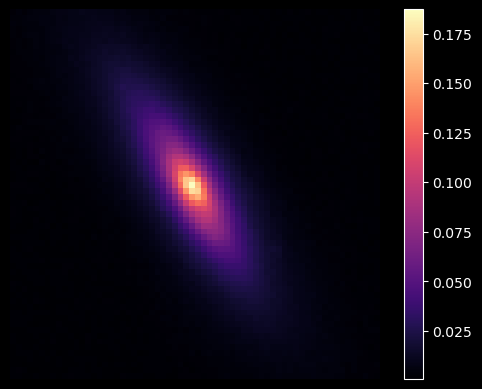

In [46]:
plt.imshow(posterior_samples.reshape(img_size, img_size).cpu(), cmap = "magma")
plt.colorbar()
plt.axis("off")